# Setup

In [87]:
import requests
from lxml import etree
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import time
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import re
import unicodedata
import warnings
import copy
import statsmodels.formula.api as smf

In [56]:
sns.set(rc={'figure.figsize':(9,7)})

In [3]:
import nltk
nltk.download(["names", "stopwords","averaged_perceptron_tagger",
               "punkt", "vader_lexicon", "wordnet"], quiet=True)

True

In [4]:
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# UDF

In [5]:
def make_lemma(text):
  """
  Function to lemmatize and clean text
  
  From: https://towardsdatascience.com/from-dataframe-to-n-grams-e34e29df3460
  """
  word_lemma = nltk.stem.WordNetLemmatizer()
  stopwords_ = nltk.corpus.stopwords.words('english')
  stopwords_.extend(['gizmos', 'feel', 'like', 'game', 'board', 'dont',
                     'bit', 'get', 'really', 'much', 'also', 'well', 'lot'])
  text = (unicodedata.normalize('NFKD', text)
    .encode('ascii', 'ignore')
    .decode('utf-8', 'ignore')
    .lower())
  words = re.sub(r'[^\w\s]', '', text).split() 
  word_li = [word_lemma.lemmatize(word) for word in words if word not in stopwords_]

  # One last move: will replace building with builder, since there's no distinction in this case
  # This is also a very commong word in the corpus
  word_li = ['builder' if word == 'building' else word for word in word_li] 

  # For some reason, stopwords isn't removing this one. Doing so manually
  if 'game' in word_li:
    word_li.remove('game')

  return word_li

In [6]:
def dataframe_to_wordlist(df, word_col):
    all_text = ''

    for i in range(len(df)):
        new_text = df.iloc[i, word_col]
        all_text += ' ' + new_text

    all_text = all_text.encode("ascii", errors="ignore").decode()
    for symbol in ['!', ',','.','_', '(', ')']:
        all_text = all_text.replace(symbol, ' ')
    
    all_text = all_text.lower()
    return all_text.split(' ')

In [66]:
def make_score_qual(score):
    if score >= 7:
        return '2.High'
    else:
        return '1.Low'

# Scrape Game Description

In [8]:
#con = sqlite3.connect('bgg.db')
#cur = con.cursor()

In [9]:
params = {'id' : '246192','stats' :'0'}
response = requests.get('https://www.boardgamegeek.com/xmlapi2/thing?', params)
soup = BeautifulSoup(response.text, "xml")
str_ = str(soup.find('description'))

In [10]:
str_ = str_.replace('<description>', '')
str_ = str_.replace('</description>', '')
str_

"The smartest minds of our generation are gathering together at the Great Science Fair. Everyone's been working hard on their creations, but only one will be crowned champion. Contestants have to think on the fly to build their machines quickly and efficiently. Whose project will be the best?&amp;#10;&amp;#10;In Gizmos, you win the game by gaining victory points from building engines. And engines help you get things done faster. Whoever builds the greatest machine and collects the most victory points wins!&amp;#10;&amp;#10;At the beginning of the game, you have 4 actions:&amp;#10;&amp;#10;     File : Put a card in the public to your Archive, allow you to build it later.&amp;#10;     Pick : Take one energy marble from the 3D marble dispenser, to your storage.&amp;#10;     Build : Build one machine and put it on action! You have to pay the marbles with colors corresponding to the card cost.&amp;#10;     Research : Draw some cards, and you can then File or Build one of the drawn cards. Th

In [11]:
comment_len = 1
comment_li = []
i = 1
game_id = '246192'
while comment_len > 0:
    params = {'id' : game_id,'comments' :'1', 'page' : str(i), 'pagesize' : str(100)}
    response = requests.get('https://www.boardgamegeek.com/xmlapi2/thing?', params)
    soup = BeautifulSoup(response.text, "xml")
    comments = soup.find_all('comment')
    for idx, com in enumerate(comments):
        comment_li.append((game_id, com['rating'], com['username'], com['value']))
    comment_len = len(comments)
    i += 1

In [12]:
df = pd.DataFrame(comment_li, columns = ['game_id', 'rating','user','description'])
df.shape

(1196, 4)

In [13]:
# Convert rating to a number
df.loc[df['rating'] == 'N/A', 'rating'] = np.nan
df.loc[:, 'rating'] = df.loc[:, 'rating'].astype(float)

In [14]:
unrated, high, low = df[pd.isna(df['rating'])].shape[0], df[df['rating'] >= 7].shape[0], df[df['rating'] < 7].shape[0]
print(unrated, high, low)

286 717 193


Text(0.5, 1.0, 'Cumulative Distribution of Scores')

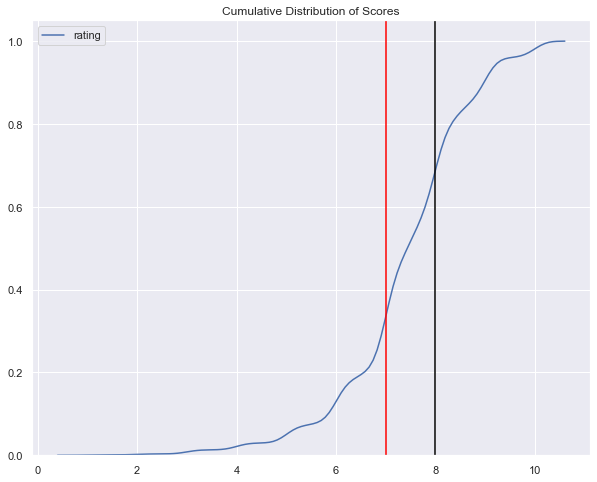

In [15]:
sns.kdeplot(df.loc[df['rating']>0, 'rating'], cumulative=True)
plt.axvline(8, 0, 1, color ='black')
plt.axvline(7, 0, 1, color ='red')
plt.title('Cumulative Distribution of Scores')

Only ~30% of scores are <= 7. Almost 70% of scores are <= 8 

In [16]:
has_rating = df[~pd.isna(df['rating'])]
has_rating.head()

,game_id,rating,user,description
1,246192,8.0,4ndrewcol3,My favorite shorter game
2,246192,6.0,Abdul,Decent but forgettable. I would have expected ...
3,246192,10.0,AbleCompany,My pick for an engine building game with just ...
4,246192,7.0,Abruptdolphin,Slimbo
5,246192,7.0,Achire,Light game. Pretty fun with all the card combo...


# NLTK Analysis

Code inspired by this site: https://realpython.com/python-nltk-sentiment-analysis/

## Let's look at phrases that appear more frequently than expected

In [17]:
bigram_measures = nltk.collocations.BigramAssocMeasures()

In [18]:
from nltk.collocations import BigramCollocationFinder

finder = BigramCollocationFinder.from_words(
    dataframe_to_wordlist(has_rating, 3))

In [19]:
temp = finder.nbest(bigram_measures.pmi, 15)
print(temp)

[('"an', 'engine"'), ('"blind', 'pick"'), ('"current', 'favorite"'), ('"engine', 'builder"'), ('"gizmos', 'market"'), ('"go', 'off"'), ('"good', 'splendor"'), ('"heavy', 'filler"'), ('"karciany"', 'przynoszcy'), ('"lost', 'designs"'), ('"next', 'step"'), ('"pick', 'up"'), ('"played', 'out"'), ('"z', 'kulkami"'), ('$', 'shipping')]


Gizmos is an engine bulding game, so it's not surpise that two of the top three results mention engine building. "Go off" probably also refers to the process of engine building. Splendor is arguably the most popular engine building game, so its no surprise to see a phrase listing it.

"Blind pick" refers to a mechanic of the game: players may get to select a random resource from the main component. "Pick up" might also refer to this mechanic

Others of note: "Lost designs" refers to a mini-exapnsion for the game. "Next step" refers to games that are a bit more complicated than intro games (e.g. Ticket to Ride) but aren't quite medium-weight games (e.g. Castles of Burgundy). "Heavy filler" is another way to explain a "next step" game. "Played out" probably refers to a game's lack of originality, while "current favorite" is self explanatory. There's also a Polish phrase in there, according to Google translate it means "card fetch." 

In [20]:
has_rating.loc[:,'lemma'] = has_rating['description'].apply(make_lemma)

In [21]:
has_rating.head()

,game_id,rating,user,description,lemma
1,246192,8.0,4ndrewcol3,My favorite shorter game,"[favorite, shorter]"
2,246192,6.0,Abdul,Decent but forgettable. I would have expected ...,"[decent, forgettable, would, expected, least, ..."
3,246192,10.0,AbleCompany,My pick for an engine building game with just ...,"[pick, engine, builder, right, kind, theming, ..."
4,246192,7.0,Abruptdolphin,Slimbo,[slimbo]
5,246192,7.0,Achire,Light game. Pretty fun with all the card combo...,"[light, pretty, fun, card, combo, mechanic, ma..."


In [22]:
all_text_li = []

for i in range(len(has_rating)):
    all_text_li.extend(has_rating.iloc[i, 4])

In [23]:
(pd.Series(nltk.ngrams(all_text_li, 2)).value_counts())[:10]

(engine, builder)      337
(marble, dispenser)     54
(potion, explosion)     37
(spice, road)           25
(chain, reaction)       24
(little, engine)        24
(century, spice)        24
(good, engine)          19
(fun, engine)           19
(splendor, century)     19
dtype: int64

It seems like it's quite common for reviews to note that Gizmos is an engine building game. Most the results note this. 

People also like to compare it to other engine building games: Century Spice Road (which takes up two slots alone, three total), Potion Explosion (which takes up one spot), and Splendor (which shares a spot with century).

People also enjoy the marble dispenser, which is the game's most remarkable component.

In [24]:
(pd.Series(nltk.ngrams(all_text_li, 3)).value_counts())[:10]

(century, spice, road)        22
(little, engine, builder)     22
(fun, engine, builder)        17
(good, engine, builder)       16
(pure, engine, builder)       14
(great, engine, builder)      12
(engine, builder, fun)        11
(splendor, century, spice)    10
(engine, builder, marble)      9
(engine, builder, great)       9
dtype: int64

Nothing remarkable here. It's an engine building game like Splendor and Century.

In [25]:
wordfreq = {}

for token in all_text_li:
    if len(token) >= 3:
        if token not in wordfreq.keys():
            wordfreq[token] = 1
        else:
            wordfreq[token] += 1

In [26]:
import heapq
most_freq = heapq.nlargest(50, wordfreq, key=wordfreq.get)
print(most_freq)

['engine', 'builder', 'marble', 'play', 'card', 'fun', 'splendor', 'good', 'one', 'combo', 'player', 'great', 'dispenser', 'build', 'action', 'would', 'little', 'turn', 'time', 'simple', 'make', 'better', 'think', 'nice', 'easy', 'played', 'still', 'interesting', 'component', 'family', 'enough', 'love', 'strategy', 'could', 'chain', 'theme', 'pretty', 'way', 'end', 'quick', 'point', 'first', 'need', 'satisfying', 'century', 'take', 'see', 'thing', 'gimmick', 'even']


In [27]:
df_copy = copy.deepcopy(has_rating)

for word in most_freq:
    df_copy[word] = 0

df_copy.reset_index(inplace=True)
df_copy.drop(labels = ['game_id', 'user', 'description', 'index'], axis=1, inplace=True)

In [28]:
for i in range(len(df_copy)):
  for word in df_copy.iloc[i, 1]:
    if word in most_freq:
      df_copy.loc[i, word] = 1

In [67]:
df_copy['opinion'] = df_copy['rating'].apply(make_score_qual)

In [68]:
df_copy.sort_values('opinion', ascending=True, inplace=True)

# Word prevlance for high and low scores

Is a term more likely to appear in the high (7+) or low (<7) review of the game. Looking at this can help us understand what people do and don't like about the game

To start, let's do a sanity check. If this exercise works at all, terms like "fun" should appear more frequently in the high reviews, and words like "gimmick" should appear more frequently in the low reviews

Text(0.5, 1.0, 'Reviews mentioning "fun"')

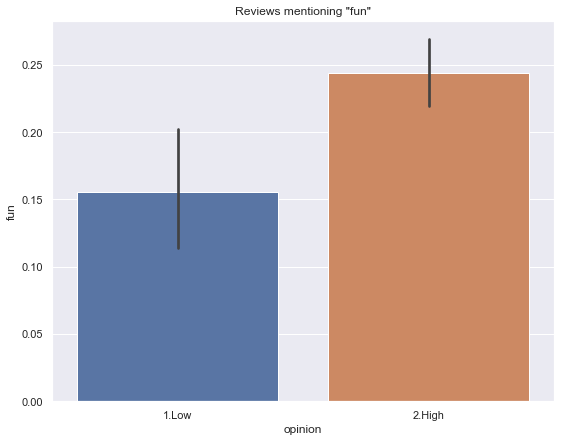

In [135]:
ax = sns.barplot(data=df_copy,x='opinion',y='fun',ci=90)
ax.set_title('Reviews mentioning "fun"')

Text(0.5, 1.0, 'Reviews mentioning "gimmick"')

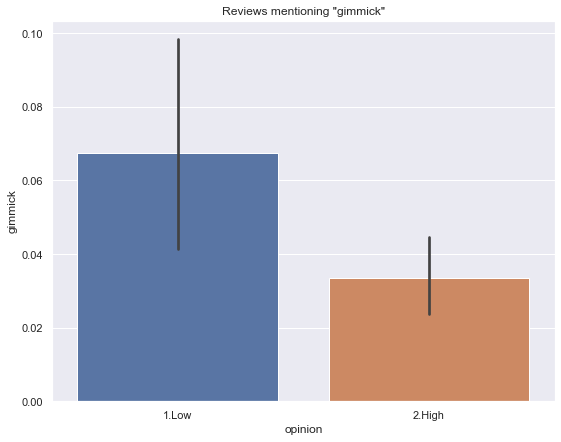

In [137]:
ax = sns.barplot(data=df_copy,x='opinion',y='gimmick',ci=90)
ax.set_title('Reviews mentioning "gimmick"')

Looks good so far. Let's check some more terms

Text(0.5, 1.0, 'Reviews mentioning "easy"')

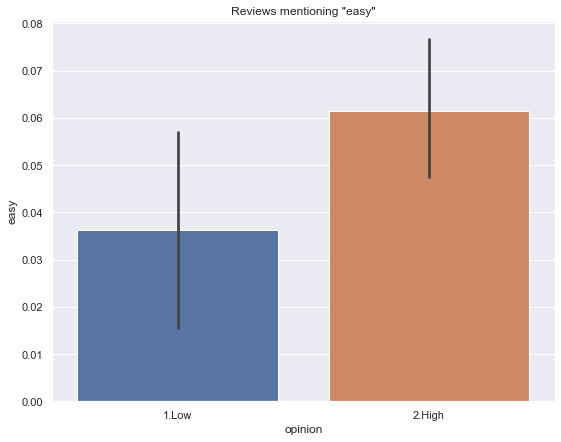

In [69]:
ax = sns.barplot(data=df_copy,x='opinion',y='easy',ci=90)
ax.set_title('Reviews mentioning "easy"')

Text(0.5, 1.0, 'Reviews mentioning "dispenser"')

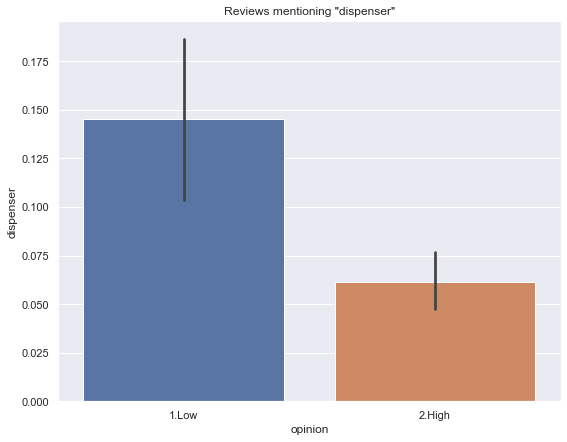

In [74]:
ax = sns.barplot(data=df_copy,x='opinion',y='dispenser',ci=90)
ax.set_title('Reviews mentioning "dispenser"')

Text(0.5, 1.0, 'Reviews mentioning "marble"')

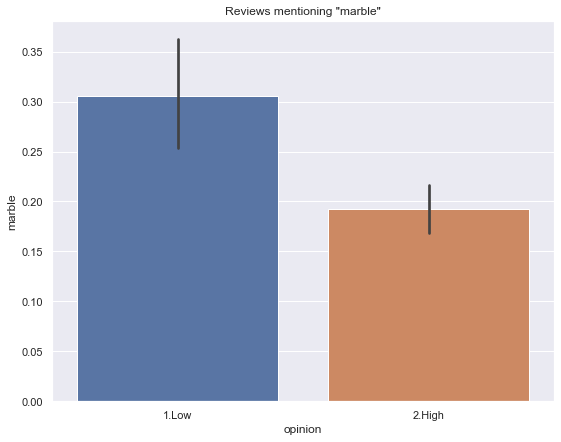

In [138]:
ax = sns.barplot(data=df_copy,x='opinion',y='marble',ci=90)
ax.set_title('Reviews mentioning "marble"')

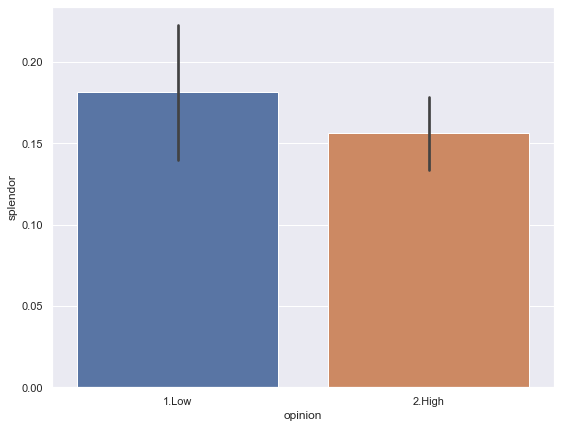

In [78]:
sns.barplot(data=df_copy,x='opinion',y='splendor',ci=90)
ax.set_title('Reviews mentioning "splendor"')

Text(0.5, 1, 'Reviews mentioning "engine"')

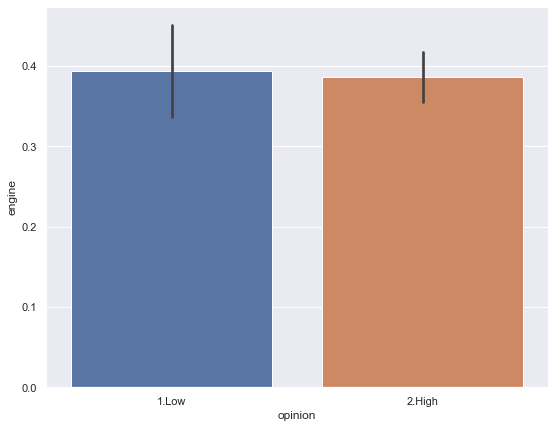

In [139]:
sns.barplot(data=df_copy,x='opinion',y='engine',ci=90)
ax.set_title('Reviews mentioning "engine"')

A few things of note:

* Positive reviews are more likely to mention that the game is easy. People enjoy its simplicity
* Negative reviews are more likely to mention the components (marbles and dispenser). I didn't expct this, so I will look into some more detail
* There didn't seem to be any difference in terms of mentioning Splendor (a similar game) or the word "engine." These are neutral descriptors of the game. One could say "I didn't like the engine building, Splendor did it better" or vice-versa

Now for my favorite: linear regression! Let's see if, holding other words constant, we see any difference in what we've discussed thus far. I chose 10 words I thought would be interesting. I included "gimmick" and "fun" in there to sanity check. We would expect those coefficients to be negative and positive, respectively

In [140]:
r = smf.ols(data = df_copy, 
       formula = '''rating ~ engine + gimmick + marble + card + fun + splendor +
       combo + player + easy + dispenser''').fit()
r.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     4.063
Date:                Mon, 11 Oct 2021   Prob (F-statistic):           1.75e-05
Time:                        17:55:49   Log-Likelihood:                -1513.5
No. Observations:                 910   AIC:                             3049.
Df Residuals:                     899   BIC:                             3102.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.4207      0.061    120.780      0.000       7.300       7.541
engine         0.0060      0.094      0.065      0.949      -0.178       0.190
gimmick       -0.4017      0.226     -1.779      0.076      -0.845       0.042
marble        -0.3228      0.125     -2.587      0.010      -0.568      -0.078
card          -0.1394      0.137     -1.016      0.310      -0.409       0.130
fun            0.2596      0.106      2.447      0.015       0.051       0.468
splendor      -0.1939      0.118     -1.643      0.101      -0.425       0.038
combo          0.0996      0.138      0.724      0.469      -0.170       0.370
player         0.0538      0.150      0.359      0.719      -0.240       0.347
easy           0.5623      0.188      2.997      0.003       0.194       0.931
dispenser     -0.2005      0.176     -1.142      0.254      -0.545       0.144
==============================================================================
Omnibus:                      112.227   Durbin-Watson:                   0.621
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              216.129
Skew:                          -0.754   Prob(JB):                     1.17e-47
Kurtosis:                       4.851   Cond. No.                         6.40
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The regression mostly shows similar info to the bar graphs: negative coefficient on marble and dispenser (thought the latter is only 25% significance), positive on easy, not significant on engine. However, there is one interesting piece of info. In the regression, a mention of Splendor reduced the expected score by about 0.2 points, and this result was almost significant at the 10% level. It seems that, holding the rest constant, reviews are more likely to negatively compare the game to Splendor

# Review Deep Dive

I wonder why marble and dispenser draw negative reviews? Let's check some comments. I'll search for the lowest rate comments that mention marble or dispenser. I'll remove comments where the length of the lemma list is less than 50. I want to remove the long reviews since they mention everything (marbles, engine, chain reaction etc.) and therefore provide no information on anything in particular

In [129]:
has_rating['review_length'] = has_rating['lemma'].apply(lambda x: len(x))
has_rating.sort_values('rating',inplace=True)
truth_values = has_rating['lemma'].apply(lambda x: 'marble' in x).values
for rating in has_rating.loc[(truth_values) & (has_rating['review_length'] < 50), 'description'].values[:10]:
    print(rating, '\n')

Very uninspired and generic vanilla boringness. Feels like it would need an overhaul expansion to even be worth playing. The premise is alright to begin with but would need to be well executed and would require an interesting twist to turn it into a solid game. Resources are all the same. Colours of gizmos are all the same. Plastic Dispenser doesn't work properly. Each Category of trigger has 1 or 2 outcomes at most across all gizmos. Also why use marbles if they just act as a resource, try using them to roll or something. Completely soulless game. 

I didn't like this much. The marble contraption is huge and unnecessary. The decisions are pretty straightforward and the engine is boring.  

Nothing special, a bare boned engine-builder with marbles. Early game goes really fast, but late game bogs down. 

First engine builder for us.  So many recommendations on forums.  Simple to learn, fun to play, yet quickly I find it a bore.  Marble dispenser is a good idea.  clever purchases gets lo

A few different thoughts about the marbles. Some say they're a gimmick, or that the dispenser is unweildly and doesn't randomize properly. Others are positive about the marbles but negative about the game, saying that the marbles look interesting but hide a boring game. Overall, it seems that negative reviews view the game as overproduced and underdeveloped.

Overproduction has been a popular critique for recent games. For instance, press coverage surrounding Tapestry focused more on it's gaudy building minatures than its gameplay

Now let's look at a positive word. What do the top reviews mentioning 'easy' have to say?"

In [133]:
has_rating['review_length'] = has_rating['lemma'].apply(lambda x: len(x))
has_rating.sort_values('rating',inplace=True, ascending=False)
truth_values = has_rating['lemma'].apply(lambda x: 'easy' in x).values
for rating in has_rating.loc[(truth_values) & (has_rating['review_length'] < 50), 'description'].values[:10]:
    print(rating, '\n')

An awesome engine builder that's so easy to learn, but there's a lot of depth in the combinations of cards you can play. Enjoyable at 2 players as well as 4 players (haven't played 3 players, but it's probably great there still). 

Simple, clean engine building distilled to its core.  By the end of the game you can make some crazy efficient engines with multiple routes to victory.  Easy to teach and to get to the table, I'd highly recommend this for anyone's collection. 

Straight to the point engine-builder.  Clear iconography.  Easy to learn.   

I love a game that is easy to pick up but strategic enough to be interesting, and Gizmos fits the bill! The branding makes it seem like a child’s game, but in fact it’s very robust and strategic! An essential for any game collection. 

Really funny game. Easy to play but hard to master! 

Fantastic engine-builder.  Cute, fast, easy to explain, easy for new players to pick it up. Most of the people I have introduced this game to have purchase

There seems to be some disagreement among the reviews. Keep in mind these are the top 10 most highly rated reviews mentioning the word easy, so they're all positive. However, some of th reviews argue the game is easy to learn while still providing lots of depth. Others argue that it's easy and, but they weren't looking for anything deep. 